In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ver.1

In [2]:
# Code source: YunGwan Hwang

# python==3.8.8
# pandas==1.2.3
# numpy==1.20.2
# scikit-learn==0.24.1
# graphviz==0.16

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={"figure.figsize": (12, 6)})
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import graphviz
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

from datetime import datetime
from joblib import dump, load
from tempfile import mkdtemp
from shutil import rmtree
cache_dir = mkdtemp()

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

class ClassifierModel(object):
    
    def __init__(
        self,
        algo_name,
        kfold,
        search,
        scoring=None,
        data=None,
        X=None,
        y=None,
        feature_scaling=None,
        n_splits=None,
        n_repeats=None,
        random_state=None):
        """
        data: It should be a pandas dataframe which 'label' column is located last.
        X: When not using dataframe, use it as features.
        y: When not using dataframe, use it as labels.
        algo_name: 'all' or classifiers list to use. (e.g. ['DecisionTreeClassifier', 'RandomForestClassifier'])
        search: 'grid' or 'random'
        scoring: 'accuracy', 'recall', 'precision', 'f1', 'roc_auc', make_scorer(precision, average='micro')...
        n_splits: int (e.g. 'n_splits=5')
        kfold: 'KFold' or 'StratifiedKFold' or 'RepeatedKFold' or 'RepeatedStratifiedKFold'
        feature_scaling: 'StandardScaler', 'MinMaxScaler', 'RobustScaler' (If you want something else, apply it in advance.)
        random_state: int (e.g. 'random_state=1')
        """
        super(ClassifierModel, self).__init__()
        self.data = data
        self.X = X
        self.y = y
        self.algo_name = algo_name
        self.search = search
        self.scoring = scoring
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.kfold = kfold
        self.feature_scaling = feature_scaling
        self.random_state = random_state

    def _scaler(self):
        if self.feature_scaling == 'StandardScaler':
            scaler = StandardScaler()
        elif self.feature_scaling == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif self.feature_scaling == 'RobustScaler':
            scaler = RobustScaler()
        else:
            return 0
        return scaler
            
    def _preprocessing(self):
        if self.X is not None and self.y is not None:
            features = np.array(self.X)
            labels = np.array(self.y)
        elif self.data is not None:
            features = self.data.iloc[:, :-1].values
            labels = self.data.iloc[:, -1].values
        else:
            raise ValueError("Input data error")
            
        if self._scaler() == 0:
            return features, labels
        else:
            scaler = self._scaler()
            scaler.fit(features)
            features_scaled = scaler.transform(features)
            return features, labels
            
    def _split_data(self):
        features, labels = self._preprocessing()
        
        return train_test_split(
            features,
            labels, 
            test_size=0.25,
            shuffle=True,
            random_state=self.random_state,
            stratify=labels
        )
    
    def _kfold(self):
        if self.n_repeats is None:
            n_repeats = 10
        else: 
            n_repeats = self.n_repeats
        kfold_list = {
            "KFold" : KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
            "StratifiedKFold" : StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
            "RepeatedKFold" : RepeatedKFold(n_splits=self.n_splits, n_repeats=n_repeats, random_state=self.random_state),
            "RepeatedStratifiedKFold" : RepeatedStratifiedKFold(n_splits=self.n_splits, n_repeats=n_repeats, random_state=self.random_state)
        }
        return kfold_list[self.kfold]
    
    def _classifiers(self):
        classifiers = {
            "MLPClassifier" : MLPClassifier,
            "KNeighborsClassifier" : KNeighborsClassifier,
            "SVC" : SVC,
            "GaussianProcessClassifier" : GaussianProcessClassifier,
            "DecisionTreeClassifier" : DecisionTreeClassifier,
            "RandomForestClassifier" : RandomForestClassifier,
            "AdaBoostClassifier" : AdaBoostClassifier,
            "GaussianNB" : GaussianNB,
            "QuadraticDiscriminantAnalysis" : QuadraticDiscriminantAnalysis,
            "GradientBoostingClassifier": GradientBoostingClassifier,
            "LogisticRegression": LogisticRegression
        }
        
        if self.algo_name == 'all':
            return classifiers
        else:
            algo_comm = list(set(self.algo_name) & set(classifiers.keys()))
            classifiers_to_use = {}
            for label in algo_comm:
                classifiers_to_use.update({label : classifiers[label]})
            return classifiers_to_use

    def _parameters(self):
        """
        You need to add parameters.
        (여기에 파라미터를 입력하기 보다는 json 파일로 따로 관리하는 것을 추천합니다.)
        """
        parameters = {}
        parameters.update(
            {
                "DecisionTreeClassifier": {
                    'criterion': ['gini', 'entropy'],
                    'splitter': ['best', 'random'],
                    'max_depth':np.arange(3, 10),
                    'min_samples_split': np.arange(2, 10),
                    'min_samples_leaf': np.arange(1, 10),
                    'max_features': ['auto', 'sqrt', 'log2']
                }
            }
        )
        parameters.update(
            {
                "RandomForestClassifier": {
                    "n_estimators": np.arange(100, 1000, 100),
                    'criterion': ['gini', 'entropy'],
                    'max_depth':np.arange(3, 10),
                    'min_samples_split': np.arange(2, 10),
                    'min_samples_leaf': np.arange(1, 10),
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'bootstrap': [True, False]
                }
            }
        )
        parameters.update(
            {
                "MLPClassifier": {
                    'max_iter':[2000],
                    'alpha':[1e-4],
                    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                    'solver' : ['lbfgs', 'sgd', 'adam'],
                    'learning_rate_init':[0.001, 0.005, 0.01],
                    'hidden_layer_sizes': [(2,),(3,)]
                }
            }
        )
        parameters.update(
            {
                "LogisticRegression": {
                    'penalty': ['l1', 'l2', 'elasticnet'],
                    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                    'max_iter': [2000],
                    'C':[0.01, 0.1, 10, 100],
                    'tol':[0.01],
                    'warm_start':[True, False],
                    'fit_intercept':[True, False]
                    
                }
            }
        )
        parameters.update(
            {
                "GradientBoostingClassifier": {
                    'loss':['deviance'],
                    'learning_rate':[0.001, 0.01, 0.1],
                    'n_estimators':np.arange(25, 500, 25),
                    'subsample': [0.5, 1.0],
                    'criterion': ['friedman_mse', 'mse'],
                    'min_samples_split': np.arange(2, 10),
                    'min_samples_leaf': np.arange(1, 10),
                    'max_depth':np.arange(3, 10),
                    'max_features':['auto', 'sqrt', 'log2', None],
                    'n_iter_no_change':[5]
                }
            }
        )
        return parameters
    
    def _evaluate_model(self, y_test, pred=None, pred_proba=None):
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred_proba)
        return accuracy, precision, recall, f1, roc_auc

    def cv_with_default_params(self):
        print(">>> Check performane with default parameters. (K-Fold: {})".format(self.n_splits))
        features, labels = self._preprocessing()
        label_count = np.unique(self._preprocessing()[1]).size
        train_size, test_size = [], []
        df_scores = pd.DataFrame()
        
        for idx, (algo_name, algo) in enumerate(self._classifiers().items()):
            n = 0
            acc_list, precision_list, recall_list, f1_list, roc_auc_list = [], [], [], [], []
            scores = {}
            for train_idx, test_idx in self._kfold().split(features, labels):
                fit_start_time = datetime.now()
                X_train, X_test = features[train_idx], features[test_idx]
                y_train, y_test = labels[train_idx], labels[test_idx]
                clf = algo()
                clf.fit(X_train, y_train)
                pred = clf.predict(X_test)
                pred_proba = clf.predict_proba(X_test)[:, 1]
                if label_count > 2:
                    acc = np.round(accuracy_score(y_test, pred), 4)
                    acc_list.append(acc)
                elif label_count == 2:
                    acc, precision, recall, f1, roc_auc = self._evaluate_model(y_test, pred, pred_proba)
                    acc_list.append(acc)
                    precision_list.append(precision)
                    recall_list.append(recall)
                    f1_list.append(f1)
                    roc_auc_list.append(roc_auc)
                else:
                    raise ValueError("One class can not create confusion matrix.")
                train_size.append(X_train.shape[0])
                test_size.append(X_test.shape[0])
                n += 1

            elapsed_time = (datetime.now() - fit_start_time).seconds
            print("{}: {}s".format(algo_name, elapsed_time))

            if label_count > 2:
                scores['accuracy'] = acc_list
                scores['rnd'] = list(range(1, self.n_splits+1))
            elif label_count == 2:
                scores['accuracy'] = acc_list
                scores['precision'] = precision_list
                scores['recall'] = recall_list
                scores['f1'] = f1_list
                scores['roc_auc'] = roc_auc_list
                scores['rnd'] = list(range(1, self.n_splits+1))
            else:
                raise ValueError("One class can not create confusion matrix.")
                
            df_tmp = pd.DataFrame(scores)
            df_tmp['algo_name'] = algo_name             
            df_scores = df_scores.append(df_tmp)
            
        for x in df_scores.columns[:-2]:
            df_tmp = df_scores[[x, 'algo_name']]
            df_tmp_agg = df_tmp.groupby('algo_name')[x].agg(mean_of_='mean')
            df_tmp = df_tmp.merge(df_tmp_agg, left_on='algo_name', right_index=True).reset_index(drop=True)
            df_tmp = df_tmp.sort_values('mean_of_', ascending=False).reset_index(drop=True)
            sns.barplot(data=df_tmp, x=x, y='algo_name')
            for index, row in df_tmp[['algo_name', 'mean_of_']].drop_duplicates().reset_index(drop=True).iterrows():
                plt.text(row.mean_of_ + 0.15, index, round(row.mean_of_, 4), color='black', ha='center', fontsize=13)
            plt.title(label=x, fontsize=14)
            plt.xticks(np.linspace(0, 1, 11), fontsize=12)
            plt.yticks(fontsize=13)
            plt.xlabel(xlabel='')
            plt.ylabel(ylabel='')
            plt.show()

    def search_params(self):
        print(">>> Search best parameters. (K-Fold: {}, CV iterations: {})".format(self.n_splits, self.n_repeats))
                
        comm_clf = self._classifiers().keys() & self._parameters().keys()
        classifiers = {}
        for label in comm_clf:
            classifiers.update({label : self._classifiers()[label]})
        
        global cv_results, best_estimator
        cv_results = pd.DataFrame()
        best_estimator = {}
        for idx, (algo_name, algo) in enumerate(classifiers.items()):
            print("---------------------------------------------------")
            print("{} start".format(algo_name))
            fit_start_time = datetime.now()
            if self.search == 'grid':
                model = GridSearchCV(
                    estimator=algo(),
                    param_grid=self._parameters()[algo_name],
                    cv=self._kfold(),
                    scoring=self.scoring,
                    n_jobs=-1,
                    return_train_score=True
                )
            elif self.search == 'random':
                model = RandomizedSearchCV(
                    estimator=algo(),
                    param_distributions=self._parameters()[algo_name],
                    cv=self._kfold(),
                    scoring=self.scoring,
                    n_iter=20,
                    n_jobs=-1,
                    return_train_score=True
                )
            X_train, X_test, y_train, y_test = self._split_data()
            model.fit(X_train, y_train)
            print("{} end (elapsed_time: {}s)".format(algo_name, (datetime.now() - fit_start_time).seconds))
            print("best params: {}".format(model.best_params_))
            best_estimator.update( {algo_name : model.best_estimator_} )
            dump(model.best_estimator_, '{}.joblib'.format(algo_name))
            
            cv_result_tmp = pd.DataFrame(model.cv_results_)
            cv_result_tmp['algo_name'] = algo_name
            cv_results = cv_results.append(cv_result_tmp)

        cv_results_1 = cv_results[cv_results.rank_test_score==1].groupby('algo_name').head(1)
        cv_results_1 = cv_results_1.sort_values('mean_test_score', ascending=False).reset_index(drop=True)

        # 모델 별 score를 데이터프레임으로 생성 (boxplot을 통해 score 분산을 확인하기 위함)
        df_tmp = pd.DataFrame()
        
        if self.n_repeats is None:
            N = self.n_splits # score 개수: k-fold의 k
        else:
            N = self.n_splits * self.n_repeats # score 개수: (k-fold의 k) x (cv 반복 횟수)
            
        for i in range(N):
            df_tmp = df_tmp.append(cv_results_1[['split{}_test_score'.format(i), 'algo_name']].rename(columns={'split{}_test_score'.format(i): 'test_score'}))
                    
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
        sns.boxplot(data=df_tmp, x='algo_name', y='test_score', ax=ax1,
                    showmeans=True,
                    meanprops={"marker":"v","markerfacecolor":"white", "markeredgecolor":"white"}
                   )
        sns.barplot(data=cv_results_1, x='algo_name', y='mean_fit_time', ax=ax2)
        ax1.tick_params(axis="x", labelsize=13, rotation=30)
        ax2.tick_params(axis="x", labelsize=13, rotation=30)
        ax1.set_xlabel(xlabel='')
        ax1.set_ylabel(ylabel='')
        ax2.set_xlabel(xlabel='')
        ax2.set_ylabel(ylabel='')
        ax1.set_title(self.scoring, fontsize=14)
        ax2.set_title('mean fit time (sec)', fontsize=14)
        for index, row in cv_results_1.iterrows():
            ax1.text(index, row.mean_test_score, round(row.mean_test_score, 4), color='black', ha='center', fontsize=13)
            ax2.text(index, row.mean_fit_time, round(row.mean_fit_time, 4), color='black', ha='center', fontsize=13)

    def precision_recall_by_thresholds(self, y_test , pred_proba_c1):
        precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

        # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
        plt.figure(figsize=(8,6))
        threshold_boundary = thresholds.shape[0]
        plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
        plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

        # threshold 값 X 축의 Scale을 0.1 단위로 변경
        start, end = plt.xlim()
        plt.xticks(np.round(np.arange(start, end, 0.1),2))

        # x축, y축 label과 legend, 그리고 grid 설정
        plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
        plt.legend(); plt.grid()
        plt.show()
                                    
    def _best_model(self):
        """
        아래의 기준에 따라 best 모델로 선정할 파라미터를 반환.
        1) mean_test_score 높은순
        2) std_test_score 낮은순
        3) mean_fit_time 낮은순
        """
        cols = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'algo_name', 'params']
        return cv_results[cols].sort_values(cols[:3], ascending=[False, True, True]).reset_index(drop=True).iloc[1, :].to_dict()
    
    def _tree_viz(self, feature_name=None, class_name=None):
        """
        Decision Tree를 시각화 할 때 사용.
        """
        if 'DecisionTreeClassifier' in best_estimator.keys():
            export_graphviz(
                decision_tree=best_estimator['DecisionTreeClassifier'],
                out_file="tree.dot",
                class_names=class_name,
                feature_names=feature_name,
                impurity=True,
                filled=True
            )
            with open("tree.dot") as f:
                dot_graph = f.read()
            return graphviz.Source(dot_graph)
        else:
            raise ValueError("Only the decision tree model can be used.")
        
    def final_classifer(self, algo_name=None):
        """
        실제 데이터에 사용할 estimator 반환.

        data: Features to predict Y.
        algo_name: 'None' or clssifier to use. (e.g. algo_name='RandomForestClassifier')
        """
        if algo_name is None:
            print(">>> Predict from new data.")
            return best_estimator[self._best_model()['algo_name']]
        else:
            print(">>> Predict from new data.")
            return best_estimator[algo_name]
        
    def feature_importances(self, index=None):
        """
        훈련 데이터로 생성된 중요도이므로 이것에 너무 의존하지 않을 필요가 있음.
        """
        feature_importances = {}
        X_train, X_test, y_train, y_test = self._split_data()
        for algo_name, algo in best_estimator.items():
            algo.fit(X_train, y_train)
            try: # tree 기반에 한해서만 feature_importances가 나옴
                feature_importances.update( {algo_name : algo.feature_importances_[:20]})
            except:
                continue
        if index is None:
            df_tmp = pd.DataFrame(feature_importances, index=self.data.columns[:-1]).T
            df_tmp.plot(kind='bar', title='Feature Importances', rot=30, figsize=(12,8));
        else:
            df_tmp = pd.DataFrame(feature_importances, index=index).T
            df_tmp.plot(kind='bar', title='Feature Importances', rot=30, figsize=(12,8));

    def permutation_importances(self, index=None):
        """
        1) 기존 test data에서 하나의 feature에 대해 row 순서를 무작위로 섞어서 새로운 test data를 생성함.
        2) 새로운 test data로 score를 측정함.
        3) 기존 test data에 의한 score 대비 어떤 새로운 test data에 의한 score를 비교함.
        4) 만약 score가 많이 감소한다면 해당 feature가 중요하다는 의미임.
        5) 혹은 score가 거의 그대로라면 해당 feature는 그닥 중요하진 않다는 의미임.
        6) 이를 통해 score가 감소하지 않는 feature를 발견한다면, 모델 튜닝 시 해당 feature를 제와하여 수행함. (성능이 올라갈 수도 있는 가능성과 리소스 확보 차원에서 도움이 될 수 있음.)
        """
        permutation_importances = {}
        X_train, X_test, y_train, y_test = self._split_data()
        for algo_name, algo in best_estimator.items():
            scores = permutation_importance(
                estimator=best_estimator[algo_name],
                X=X_test,
                y=y_test,
                scoring=self.scoring,
                n_repeats=10,
                n_jobs=-1,
                random_state=self.random_state
            )
            permutation_importances.update( {algo_name : scores} )
            
        fig, ax = plt.subplots()        
        for algo_name in permutation_importances.keys():
            if index is None:
                sns.boxplot(
                    data=pd.DataFrame(permutation_importances[algo_name]['importances'].T, columns=self.data.columns[:-1]),
                    orient='h',
                    showmeans=True,
                    meanprops={"marker":"v","markerfacecolor":"white"}
                )
                plt.title('permutation importances ({})'.format(algo_name), fontsize=13)
                plt.show()
            else:
                sns.boxplot(
                    data=pd.DataFrame(permutation_importances[algo_name]['importances'].T, columns=index),
                    orient='h',
                    showmeans=True,
                    meanprops={"marker":"v","markerfacecolor":"white"}
                )
                plt.title('permutation importances ({})'.format(algo_name), fontsize=13)
                plt.show()

>>> Check performane with default parameters. (K-Fold: 5)
DecisionTreeClassifier: 0s
GradientBoostingClassifier: 0s
RandomForestClassifier: 0s


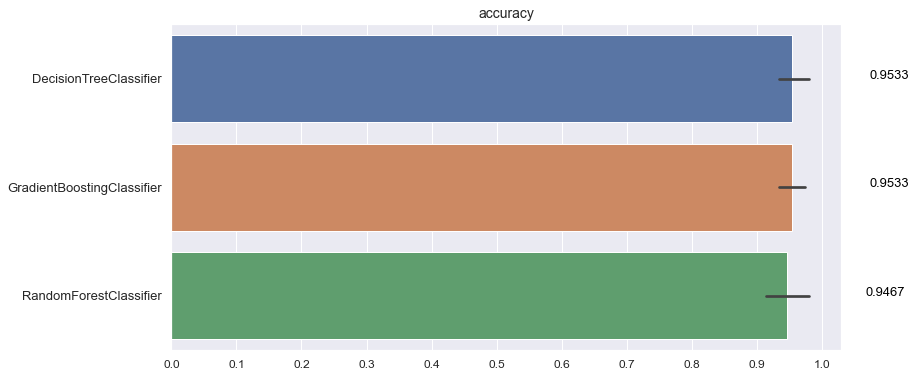

>>> Search best parameters. (K-Fold: 5, CV iterations: None)
---------------------------------------------------
DecisionTreeClassifier start
DecisionTreeClassifier end (elapsed_time: 1s)
best params: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}
---------------------------------------------------
GradientBoostingClassifier start
GradientBoostingClassifier end (elapsed_time: 9s)
best params: {'subsample': 1.0, 'n_iter_no_change': 5, 'n_estimators': 75, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.01, 'criterion': 'mse'}
---------------------------------------------------
RandomForestClassifier start
RandomForestClassifier end (elapsed_time: 11s)
best params: {'n_estimators': 400, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'entropy', 'bootstrap': True}
>>> Predict from 

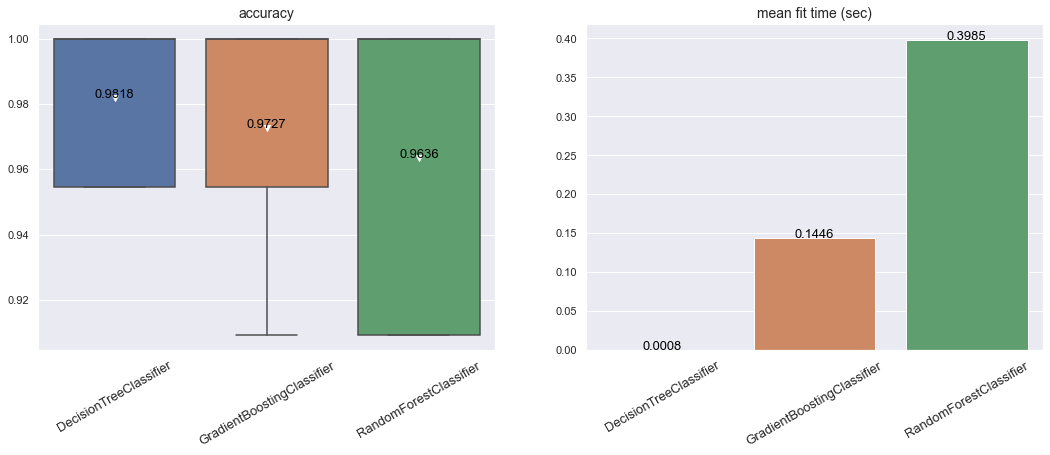

In [3]:
# iris 데이터 적용 예시
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)

from sklearn.datasets import load_iris
iris = load_iris()
df_iris = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df_iris['label'] = iris['target']

# 모델 생성
clf = ClassifierModel(
    data=df_iris, # 데이터 프레임으로 넣어야 합니다. 단, 종속변수 컬럼은 맨 오른쪽 끝에 위치해 있어야 합니다.
		# X=X # 데이터 프레임을 사용하지 않고 feature를 넣어도 됩니다.
		# y=y # 데이터 프레임을 사용하지 않고 label을 넣어도 됩니다.
    algo_name=['DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier'], # 모델을 지정주세요. 이떄, 'all'로 하면 sklearn의 모든 분류기가 적용 돼요.
    search='random', # 'gird'와 'random' 중 선택해주세요.
    scoring='accuracy', # 파라미터 튜닝 시 사용할 척도
    n_splits=5, # K-Fold는 디폴드가 5입니다. 따로 지정해주셔도 됩니다. 일반적으로 3, 5, 10을 많이 사용합니다
    kfold='StratifiedKFold',
    feature_scaling='MinMaxScaler', # Standard, MinMax, Robust 중 선택해주세요. 그 외에는 직접 전처리 후 데이터를 넣어야 합니다. 만약 사용하지 않을 거라면 파라미터를 빼주시면 돼요.
    random_state=41
)

# 기본 파라미터로 성능 비교
clf.cv_with_default_params()

# 하이퍼 파라미터에 따라 성능 비교
clf.search_params()

# 최종 선택된 모델로 실제 데이터를 예측
model = clf.final_classifer()
pred = model.predict(df_iris.iloc[:, :-1])
print(accuracy_score(df_iris['label'], pred))

# Ver.2

In [2]:
# Code source: YunGwan Hwang

# python==3.8.8
# pandas==1.2.3
# numpy==1.20.2
# scikit-learn==0.24.1
# graphviz==0.16
# xgboost==1.3.3
# lightgbm==3.2.0


import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={"figure.figsize": (12, 6)})
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import graphviz
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint
from datetime import datetime
from joblib import dump, load
from tempfile import mkdtemp
from shutil import rmtree
cache_dir = mkdtemp()

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
# from sklearn.feature_selection import SelectKBest, chi2
from sklearn.experimental import enable_halving_search_cv

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier


class ClassifierModel(object):
    
    def __init__(
        self,
        kfold,
        scoring=None,
        data=None,
        X=None,
        y=None,
        feature_scaling=None,
        n_splits=None,
        n_repeats=None,
        random_state=None):
        """
        data: It should be a pandas dataframe which 'label' column is located last.
        X: When not using dataframe, use it as features.
        y: When not using dataframe, use it as labels.
        algo_name: 'all' or classifiers list to use. (e.g. ['DecisionTreeClassifier', 'RandomForestClassifier'])
        search: 'grid' or 'random'
        scoring: 'accuracy', 'recall', 'precision', 'f1', 'roc_auc', make_scorer(precision, average='micro')...
        n_splits: int (e.g. 'n_splits=5')
        kfold: 'KFold' or 'StratifiedKFold' or 'RepeatedKFold' or 'RepeatedStratifiedKFold'
        feature_scaling: 'StandardScaler', 'MinMaxScaler', 'RobustScaler' (If you want something else, apply it in advance.)
        random_state: int (e.g. 'random_state=1')
        """
        super(ClassifierModel, self).__init__()
        self.data = data
        self.X = X
        self.y = y
        self.scoring = scoring
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.kfold = kfold
        self.feature_scaling = feature_scaling
        self.random_state = random_state

    def _scaler(self):
        if self.feature_scaling == 'StandardScaler':
            scaler = StandardScaler()
        elif self.feature_scaling == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif self.feature_scaling == 'RobustScaler':
            scaler = RobustScaler()
        else:
            return 0
        return scaler
            
    def _preprocessing(self):
        if self.X is not None and self.y is not None:
            features = np.array(self.X)
            labels = np.array(self.y)
        elif self.data is not None:
            features = self.data.iloc[:, :-1].values
            labels = self.data.iloc[:, -1].values
        else:
            raise ValueError("Input data error")
            
        if self._scaler() == 0:
            return features, labels
        else:
            scaler = self._scaler()
            scaler.fit(features)
            features_scaled = scaler.transform(features)
            return features, labels
            
    def _split_data(self):
        features, labels = self._preprocessing()
        
        return train_test_split(
            features,
            labels, 
            test_size=0.25,
            shuffle=True,
            random_state=self.random_state,
            stratify=labels
        )
    
    def _kfold(self, n_splits, n_repeats):
        if n_repeats is None:
            n_repeats = 10
        else: 
            n_repeats = self.n_repeats
        kfold_list = {
            "KFold" : KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
            "StratifiedKFold" : StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
            "RepeatedKFold" : RepeatedKFold(n_splits=self.n_splits, n_repeats=n_repeats, random_state=self.random_state),
            "RepeatedStratifiedKFold" : RepeatedStratifiedKFold(n_splits=self.n_splits, n_repeats=n_repeats, random_state=self.random_state)
        }
        return kfold_list[self.kfold]
    
    def _classifiers(self):
        classifiers = {
            "MLPClassifier" : MLPClassifier,
            "KNeighborsClassifier" : KNeighborsClassifier,
            "SVC" : SVC,
            "GaussianProcessClassifier" : GaussianProcessClassifier,
            "DecisionTreeClassifier" : DecisionTreeClassifier,
            "RandomForestClassifier" : RandomForestClassifier,
            "AdaBoostClassifier" : AdaBoostClassifier,
            "GaussianNB" : GaussianNB,
            "QuadraticDiscriminantAnalysis" : QuadraticDiscriminantAnalysis,
            "GradientBoostingClassifier": GradientBoostingClassifier,
            "LogisticRegression": LogisticRegression,
            "XGBClassifier": XGBClassifier,
            "LGBMClassifier": LGBMClassifier
        }
        return classifiers
        
#         if self.algo_name == 'all':
#             return classifiers
#         else:
#             algo_comm = list(set(self.algo_name) & set(classifiers.keys()))
#             classifiers_to_use = {}
#             for label in algo_comm:
#                 classifiers_to_use.update({label : classifiers[label]})
#             return classifiers_to_use

    def _parameters(self):
        """
        You need to add parameters.
        (여기에 파라미터를 입력하기 보다는 json 파일로 따로 관리하는 것을 추천합니다.)
        """
        parameters = {
            "DecisionTreeClassifier": {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth':np.arange(3, 10),
                'min_samples_split': np.arange(2, 10),
                'min_samples_leaf': np.arange(1, 10),
                'max_features': ['auto', 'sqrt', 'log2']
            },
            "RandomForestClassifier": {
                "n_estimators": np.arange(100, 1000, 100),
                'criterion': ['gini', 'entropy'],
                'max_depth':np.arange(3, 10),
                'min_samples_split': np.arange(2, 10),
                'min_samples_leaf': np.arange(1, 10),
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]
            },
            "MLPClassifier": {
                'max_iter':[2000],
                'alpha':[1e-4],
                'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                'solver' : ['lbfgs', 'sgd', 'adam'],
                'learning_rate_init':[0.001, 0.005, 0.01],
                'hidden_layer_sizes': [(2,),(3,)]
            },
            "LogisticRegression": {
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                'max_iter': [2000],
                'C':[0.01, 0.1, 10, 100],
                'tol':[0.01],
                'warm_start':[True, False],
                'fit_intercept':[True, False]  
            },
            "GradientBoostingClassifier": {
                'loss':['deviance'],
                'learning_rate':[0.001, 0.01, 0.1],
                'n_estimators':np.arange(25, 500, 25),
                'subsample': [0.5, 1.0],
                'criterion': ['friedman_mse', 'mse'],
                'min_samples_split': np.arange(2, 10),
                'min_samples_leaf': np.arange(1, 10),
                'max_depth':np.arange(3, 10),
                'max_features':['auto', 'sqrt', 'log2', None],
                'n_iter_no_change':[5]
            },
            "XGBClassifier": {
                'n_estimators': np.arange(50, 1000, 50),
                'learning_rate': np.arange(0.001, 0.1, 0.01),
                'max_depth': range(3, 10),
                'colsample_bytree': [i/10.0 for i in range(1, 3)],
                'gamma': [i/10.0 for i in range(3)]
            },
            "LGBMClassifier": {
                'n_estimators': np.arange(50, 1000, 50),
                'learning_rate': np.arange(0.001, 0.1, 0.01),
                'max_depth': range(3, 10),                
                'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#                 'num_leaves': sp_randint(6, 50), 
#                 'min_child_samples': sp_randint(100, 500), 
#                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#                 'subsample': sp_uniform(loc=0.2, scale=0.8), 
#                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
#                 'scale_pos_weight':[1,2,6,12]
            }
        }
        if ('XGBClassifier' in parameters.keys()) or ('LGBMClassifier' in parameters.keys()):
            if np.unique(self._preprocessing()[1]).size > 2:
                parameters['XGBClassifier']['objective'] = ['multi:softprob']
                parameters['LGBMClassifier']['objective'] = ['multiclass']
            else:
                parameters['XGBClassifier']['objective'] = ['binary:logistic']
                parameters['LGBMClassifier']['objective'] = ['binary']
        else:
            pass
        return parameters
    
    def _fit_params(self, algo_name):
        """
        XGBoost, LightGBM로 fit할 때 early_stopping_rounds, eval_metric 사용하기 위한 용도
        """
        if np.unique(self._preprocessing()[1]).size == 2:
            if algo_name == 'XGBClassifier':
                return {'early_stopping_rounds': 100, 'eval_metric': 'logloss', 'verbose':False}
            elif algo_name == 'LGBMClassifier':
                return {'early_stopping_rounds': 100, 'eval_metric': 'binary_logloss', 'verbose':False}
                
        else:
            if algo_name == 'XGBClassifier':
                return {'early_stopping_rounds': 100, 'eval_metric': 'mlogloss', 'verbose':False}
            elif algo_name == 'LGBMClassifier':
                return {'early_stopping_rounds': 100, 'eval_metric': 'multi_logloss', 'verbose':False}
    
    def cv_with_default_params(self, algo_names):
        
        if algo_names == 'all':
            classifiers = self._classifiers()
        else:
            algo_comm = list(set(algo_names) & set(self._classifiers().keys()))
            classifiers = {}
            for label in algo_comm:
                classifiers.update({label : self._classifiers()[label]})
        
        print(">>> Check performane with default parameters. (K-Fold: {}, CV iterations: {})".format(self.n_splits, self.n_repeats))
        features, labels = self._preprocessing()
        label_count = np.unique(self._preprocessing()[1]).size
        df_scores = pd.DataFrame()
        
        for idx, (algo_name, algo) in enumerate(classifiers.items()):
            print("---------------------------------------------------")
            print("{} start".format(algo_name))
            fit_start_time = datetime.now()
            if label_count > 2:
                df_tmp = pd.DataFrame(cross_validate(estimator=algo(),
                                                     X=features, y=labels,
                                                     cv=self._kfold(),
                                                     scoring=self.scoring,
                                                     n_jobs=-1)
                                     )
                df_tmp['scoring'] = self.scoring
                df_tmp['algo_name'] = algo_name
                df_scores = df_scores.append(df_tmp)
            elif label_count == 2:
                for scoring in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
                    df_tmp = pd.DataFrame(cross_validate(estimator=algo(),
                                                         X=features, y=labels,
                                                         cv=self._kfold(),
                                                         scoring=scoring,
                                                         n_jobs=-1)
                                         )
                    df_tmp['scoring'] = scoring
                    df_tmp['algo_name'] = algo_name
                    df_scores = df_scores.append(df_tmp)
            else:
                raise ValueError("One class can not create confusion matrix.")
            print("{} end (elapsed_time: {}s)".format(algo_name, (datetime.now() - fit_start_time).seconds))
                
        df_agg = df_scores.groupby(['algo_name', 'scoring']).agg(mean_test_score=('test_score', 'mean'), mean_fit_time=('fit_time', 'mean')).reset_index()
        df_scores = df_scores.merge(df_agg, on=['algo_name', 'scoring']).reset_index(drop=True)
        df_scores = df_scores.sort_values(['scoring', 'mean_test_score', 'algo_name'], ascending=[True, False, True]).reset_index(drop=True)
        
        for scoring in df_scores.scoring.unique():
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            sns.boxplot(data=df_scores[df_scores['scoring']==scoring], x='algo_name', y='test_score', ax=ax1, showmeans=True, meanprops={"marker":"v","markerfacecolor":"white", "markeredgecolor":"white"})
            sns.boxplot(data=df_scores[df_scores['scoring']==scoring], x='algo_name', y='fit_time', ax=ax2, showmeans=True, meanprops={"marker":"v","markerfacecolor":"white", "markeredgecolor":"white"})
            ax1.tick_params(axis="x", labelsize=13, rotation=30)
            ax2.tick_params(axis="x", labelsize=13, rotation=30)
            ax1.set_xlabel(xlabel='')
            ax1.set_ylabel(ylabel='')
            ax2.set_xlabel(xlabel='')
            ax2.set_ylabel(ylabel='')
            ax1.set_title(scoring, fontsize=14)
            ax2.set_title('fit time (sec)', fontsize=14)
            df_tmp = df_scores[df_scores['scoring']==scoring][['algo_name', 'mean_test_score', 'mean_fit_time']].drop_duplicates().reset_index(drop=True)
            for index, row in df_tmp.iterrows():
                ax1.text(index, row.mean_test_score, round(row.mean_test_score, 4), color='black', ha='center', fontsize=13)
                ax2.text(index, row.mean_fit_time, round(row.mean_fit_time, 4), color='black', ha='center', fontsize=13)
        return df_scores

    def search_params(self, search, algo_names):
        print(">>> Search best parameters. (K-Fold: {}, CV iterations: {})".format(self.n_splits, self.n_repeats))
                
        comm_clf = self._classifiers().keys() & self._parameters().keys() & algo_names
        classifiers = {}
        for label in comm_clf:
            classifiers.update({label : self._classifiers()[label]})
            
        X_train, X_test, y_train, y_test = self._split_data()
        
        global cv_results, best_estimator
        cv_results = pd.DataFrame()
        best_estimator = {}
        for idx, (algo_name, algo) in enumerate(classifiers.items()):
            print("---------------------------------------------------")
            print("{} start".format(algo_name))
            fit_start_time = datetime.now()
            if search == 'grid':
                if (algo_name == 'XGBClassifier') or (algo_name == 'LGBMClassifier'):
                    model = GridSearchCV(estimator=algo(),
                                         param_grid=self._parameters()[algo_name],
                                         fit_params=self._fit_params(algo_name=algo_name),
                                         cv=self._kfold(),
                                         scoring=self.scoring,
                                         n_jobs=-1,
                                         return_train_score=True)
                    model.fit(X_train, y_train)
                else:
                    model = GridSearchCV(estimator=algo(),
                                         param_grid=self._parameters()[algo_name],
                                         cv=self._kfold(),
                                         scoring=self.scoring,
                                         n_jobs=-1,
                                         return_train_score=True)
                    model.fit(X_train, y_train)
            elif search == 'random':
                model = RandomizedSearchCV(estimator=algo(),
                                           param_distributions=self._parameters()[algo_name],
                                           cv=self._kfold(),
                                           scoring=self.scoring,
                                           n_iter=20,
                                           n_jobs=-1,
                                           return_train_score=True)
                if (algo_name == 'XGBClassifier') or (algo_name == 'LGBMClassifier'):
                    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], **self._fit_params(algo_name=algo_name))
                else:
                    model.fit(X_train, y_train)

            print("{} end (elapsed_time: {}s)".format(algo_name, (datetime.now() - fit_start_time).seconds))
            print("best params: {}".format(model.best_params_))
            best_estimator.update( {algo_name : model.best_estimator_} )
            dump(model.best_estimator_, '{}.joblib'.format(algo_name))
            
            cv_result_tmp = pd.DataFrame(model.cv_results_)
            cv_result_tmp['algo_name'] = algo_name
            cv_results = cv_results.append(cv_result_tmp)

        cv_results_1 = cv_results[cv_results.rank_test_score==1].groupby('algo_name').head(1)
        cv_results_1 = cv_results_1.sort_values('mean_test_score', ascending=False).reset_index(drop=True)

        # 모델 별 score를 데이터프레임으로 생성 (boxplot을 통해 score 분산을 확인하기 위함)
        df_tmp = pd.DataFrame()
        
        if self.n_repeats is None:
            N = self.n_splits # score 개수: k-fold의 k
        else:
            N = self.n_splits * self.n_repeats # score 개수: (k-fold의 k) x (cv 반복 횟수)
            
        for i in range(N):
            df_tmp = df_tmp.append(cv_results_1[['split{}_test_score'.format(i), 'algo_name']].rename(columns={'split{}_test_score'.format(i): 'test_score'}))
                    
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
        sns.boxplot(data=df_tmp, x='algo_name', y='test_score', ax=ax1, showmeans=True, meanprops={"marker":"v","markerfacecolor":"white", "markeredgecolor":"white"})
        sns.barplot(data=cv_results_1, x='algo_name', y='mean_fit_time', ax=ax2)
        ax1.tick_params(axis="x", labelsize=13, rotation=30)
        ax2.tick_params(axis="x", labelsize=13, rotation=30)
        ax1.set_xlabel(xlabel='')
        ax1.set_ylabel(ylabel='')
        ax2.set_xlabel(xlabel='')
        ax2.set_ylabel(ylabel='')
        ax1.set_title(self.scoring, fontsize=14)
        ax2.set_title('mean fit time (sec)', fontsize=14)
        for index, row in cv_results_1.iterrows():
            ax1.text(index, row.mean_test_score, round(row.mean_test_score, 4), color='black', ha='center', fontsize=13)
            ax2.text(index, row.mean_fit_time, round(row.mean_fit_time, 4), color='black', ha='center', fontsize=13)

    def evaluate_model(self, y_test, pred=None, pred_proba=None):
        label_count = np.unique(self._preprocessing()[1]).size
        if label_count > 2:
             return accuracy_score(y_test, pred)
        else:            
            accuracy = accuracy_score(y_test, pred)
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            f1 = f1_score(y_test, pred)
            roc_auc = roc_auc_score(y_test, pred_proba)
            return accuracy, precision, recall, f1, roc_auc
            
    def precision_recall_by_thresholds(self):
        """
        threshold에 따른 이진 분류 성능 확인을 위한 정밀도, 재현율 확인
        """
        X_train, X_test, y_train, y_test = self._split_data()
        
        for algo_name, algo in best_estimator.items():
            pred_proba_class1 = algo.predict_proba(X_test)[:, 1]
            precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
            
            plt.figure(figsize=(8, 6))
            threshold_boundary = thresholds.shape[0]
            plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
            plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
            plt.title('Precision and Recall by Threshold ({})'.format(algo_name))
            start, end = plt.xlim()
            plt.xticks(np.round(np.arange(start, end, 0.1), 2))
            plt.xlabel('Threshold')
            plt.ylabel('Precision and Recall')
            plt.legend()
            plt.grid();
                                    
    def _best_model(self):
        """
        아래의 기준에 따라 best 모델로 선정할 파라미터를 반환.
        1) mean_test_score 높은순
        2) std_test_score 낮은순
        3) mean_fit_time 낮은순
        """
        cols = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'algo_name', 'params']
        return cv_results[cols].sort_values(cols[:3], ascending=[False, True, True]).reset_index(drop=True).iloc[1, :].to_dict()
            
    def final_classifer(self, algo_name=None):
        """
        실제 데이터에 사용할 estimator 반환.

        data: Features to predict Y.
        algo_name: 'None' or clssifier to use. (e.g. algo_name='RandomForestClassifier')
        """
        if algo_name is None:
            print(">>> Predict from new data.")
            return best_estimator[self._best_model()['algo_name']]
        else:
            print(">>> Predict from new data.")
            return best_estimator[algo_name]
        
    def feature_importances(self, index=None):
        """
        훈련 데이터로 생성된 중요도이므로 이것에 너무 의존하지 않을 필요가 있음.
        """
        feature_importances = {}
        for algo_name, algo in best_estimator.items():
            print(algo_name)
            try: # tree 기반에 한해서만 feature_importances가 나옴
                fi = algo.feature_importances_ / algo.feature_importances_.sum()
                feature_importances.update( {algo_name : fi[:20]} )
            except:
                continue
                
        if index is None:
            df_tmp = pd.DataFrame(feature_importances, index=self.data.columns[:-1]).T
            df_tmp.plot(kind='bar', title='Feature Importances', rot=30, figsize=(12,8));
        else:
            df_tmp = pd.DataFrame(feature_importances, index=index).T
            df_tmp.plot(kind='bar', title='Feature Importances', rot=30, figsize=(12,8));

    def permutation_importances(self, index=None):
        """
        1) 기존 test data에서 하나의 feature에 대해 row 순서를 무작위로 섞어서 새로운 test data를 생성함.
        2) 새로운 test data로 score를 측정함.
        3) 기존 test data에 의한 score 대비 새로운 test data에 의한 score를 비교함.
        4) 만약 score가 많이 감소한다면 해당 feature가 중요하다는 의미임.
        5) 혹은 score가 거의 그대로라면 해당 feature는 그닥 중요하진 않다는 의미임.
        6) 이를 통해 score가 감소하지 않는 feature를 발견한다면, 모델 튜닝 시 해당 feature를 제와하여 수행함. (성능이 올라갈 수도 있는 가능성과 리소스 확보 차원에서 도움이 될 수 있음.)
        """
        permutation_importances = {}
        X_train, X_test, y_train, y_test = self._split_data()
        for algo_name, algo in best_estimator.items():
            scores = permutation_importance(
                estimator=best_estimator[algo_name],
                X=X_test,
                y=y_test,
                scoring=self.scoring,
                n_repeats=10,
                n_jobs=-1,
                random_state=self.random_state
            )
            permutation_importances.update( {algo_name : scores} )
            
        fig, ax = plt.subplots()        
        for algo_name in permutation_importances.keys():
            if index is None:
                sns.boxplot(
                    data=pd.DataFrame(permutation_importances[algo_name]['importances'].T, columns=self.data.columns[:-1]),
                    orient='h',
                    showmeans=True,
                    meanprops={"marker":"v","markerfacecolor":"white"}
                )
                plt.title('permutation importances ({})'.format(algo_name), fontsize=13)
                plt.show()
            else:
                sns.boxplot(
                    data=pd.DataFrame(permutation_importances[algo_name]['importances'].T, columns=index),
                    orient='h',
                    showmeans=True,
                    meanprops={"marker":"v","markerfacecolor":"white"}
                )
                plt.title('permutation importances ({})'.format(algo_name), fontsize=13)
                plt.show()
                
    def _tree_viz(self, feature_name=None, class_name=None):
        """
        Decision Tree를 시각화 할 때 사용.
        """
        if 'DecisionTreeClassifier' in best_estimator.keys():
            export_graphviz(
                decision_tree=best_estimator['DecisionTreeClassifier'],
                out_file="tree.dot",
                class_names=class_name,
                feature_names=feature_name,
                impurity=True,
                filled=True
            )
            with open("tree.dot") as f:
                dot_graph = f.read()
            return graphviz.Source(dot_graph)
        else:
            raise ValueError("Only the decision tree model can be used.")

In [258]:
# iris 데이터 적용 예시
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)

from sklearn.datasets import load_iris
iris = load_iris()
df_iris = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df_iris['label'] = iris['target']

# 모델 생성
clf = ClassifierModel(
    data=df_iris, # pandas로 넣어야 합니다. 단, 종속변수(label) 컬럼은 맨 오른쪽 끝에 위치해 있어야 합니다.
		# X=X, X와 y에 따로 데이터를 넣어도 됩니다. 이때는 pandas, numpy 뭐든 상관 없어요.
		# y=y,
    algo_name=[ # 모델을 지정주세요. 이떄, 'all'로 하면 sklearn의 모든 분류기가 적용 돼요.
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'GradientBoostingClassifier',
        'XGBClassifier',
        'LGBMClassifier'
    ],
    scoring='accuracy', # 확인할 성능 지표를 입력해주세요.
    n_splits=5, # K-Fold의 K 값입니다. 기본값이 5라서 따로 지정하지 않으셔도 됩니다. 일반적으로 3, 5, 10을 많이 사용합니다.
    n_repeats=5, # Cross Validation 반복 횟수입니다. 기본값은 10입니다만, 5로 해도 충분한 것 같습니다. 'RepeatedStratifiedKFold'와 'RepeatedKFold'에 한해서 동작합니다.
    kfold='RepeatedStratifiedKFold', # 훈련, 검증 데이터를 나눌 때 사용할 방법을 지정해주세요. 클래스 불균형이 크다면 묻고 따지지도 않고 Stratified로 갑시다.
    feature_scaling='MinMaxScaler', # Standard, MinMax, Robust 중 선택해주세요. 그 외에는 직접 전처리 후 데이터를 넣어야 합니다. 만약 사용하지 않을 거라면 파라미터를 빼주시면 돼요.
    random_state=30 # 올해 서른이라 30으로 해봤읍니다..
)

>>> Check performane with default parameters. (K-Fold: 5, CV iterations: 5)
---------------------------------------------------
LGBMClassifier start
LGBMClassifier end (elapsed_time: 1s)
---------------------------------------------------
XGBClassifier start
XGBClassifier end (elapsed_time: 0s)
---------------------------------------------------
DecisionTreeClassifier start
DecisionTreeClassifier end (elapsed_time: 0s)
---------------------------------------------------
GradientBoostingClassifier start
GradientBoostingClassifier end (elapsed_time: 1s)
---------------------------------------------------
RandomForestClassifier start
RandomForestClassifier end (elapsed_time: 0s)


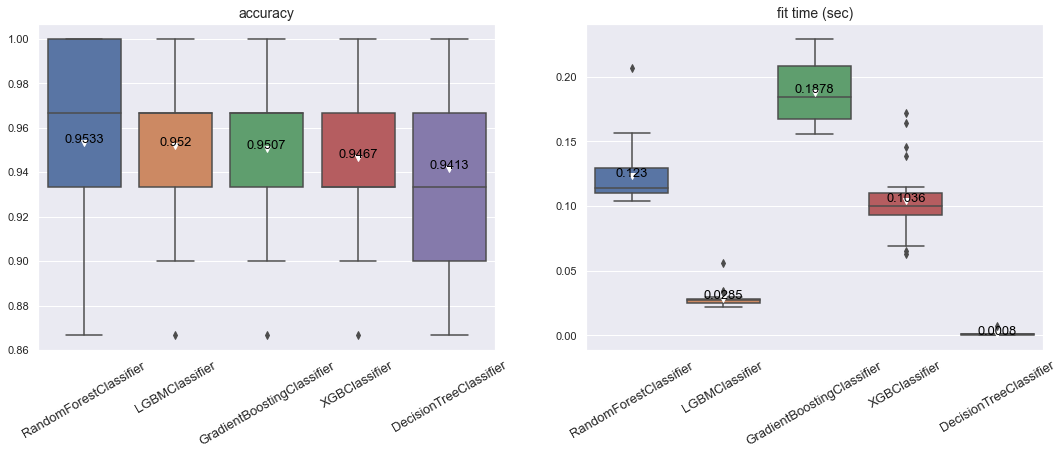

In [171]:
# 기본 파라미터로 성능 비교
df_scores = clf.cv_with_default_params()

>>> Search best parameters. (K-Fold: 5, CV iterations: 5)
---------------------------------------------------
LGBMClassifier start
LGBMClassifier end (elapsed_time: 4s)
best params: {'colsample_bytree': 0.8375649986663085, 'learning_rate': 0.08099999999999999, 'max_depth': 5, 'n_estimators': 300, 'objective': 'multiclass'}
---------------------------------------------------
XGBClassifier start
XGBClassifier end (elapsed_time: 29s)
best params: {'objective': 'multi:softprob', 'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.040999999999999995, 'gamma': 0.2, 'colsample_bytree': 0.2}
---------------------------------------------------
DecisionTreeClassifier start
DecisionTreeClassifier end (elapsed_time: 0s)
best params: {'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'entropy'}
---------------------------------------------------
GradientBoostingClassifier start
GradientBoostingClassifier end (elapsed_time: 

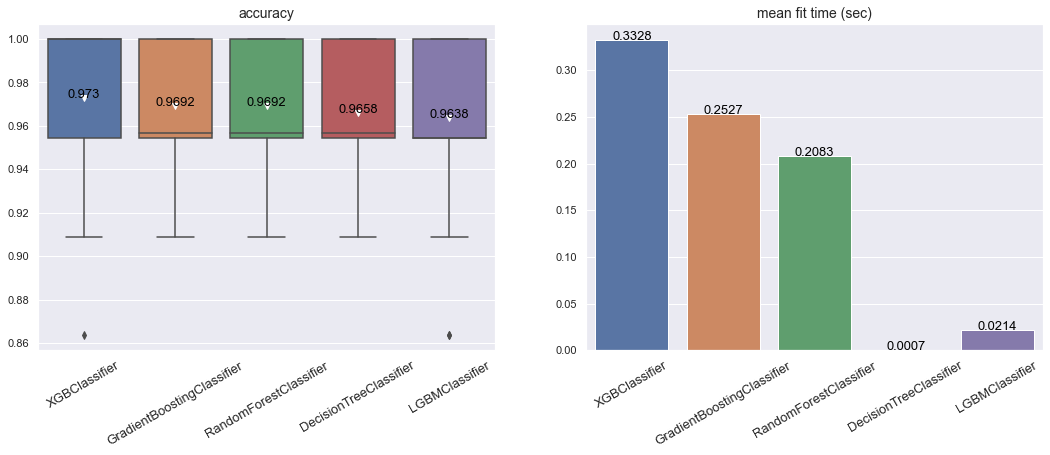

In [259]:
# 하이퍼 파라미터에 따라 성능 비교
clf.search_params(search='random')

LGBMClassifier
XGBClassifier
DecisionTreeClassifier
GradientBoostingClassifier
RandomForestClassifier


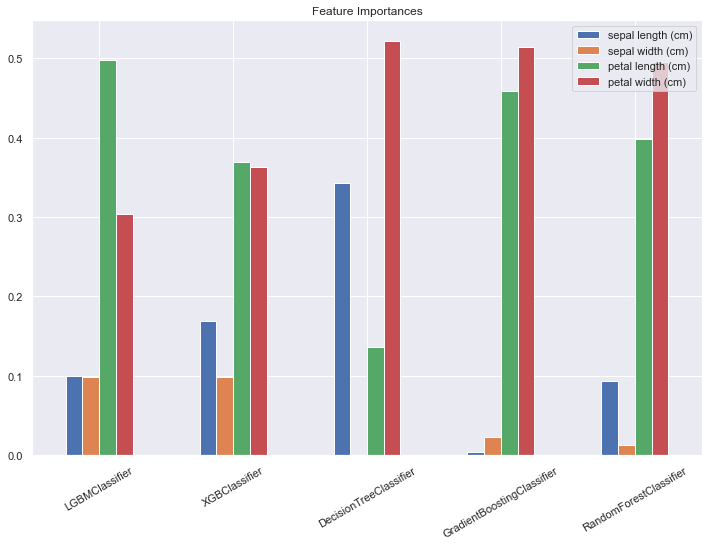

In [168]:
# 각 모델 별 Feature Importances 확인
clf.feature_importances()

In [ ]:
# 최종 선택된 모델로 실제 데이터를 예측
model = clf.final_classifer()
pred = model.predict(df_iris.iloc[:, :-1].values)
print(accuracy_score(df_iris['label'], pred))

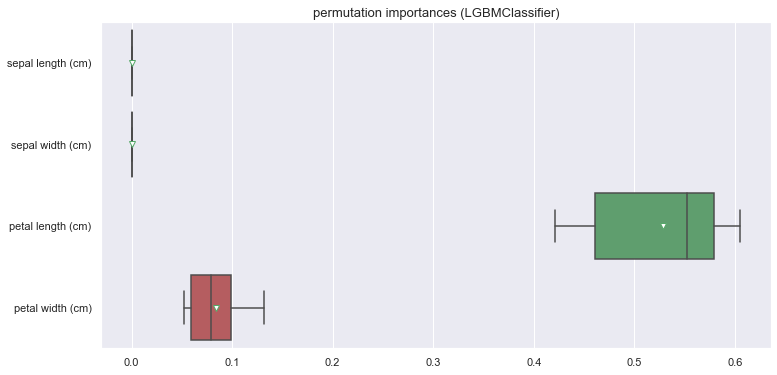

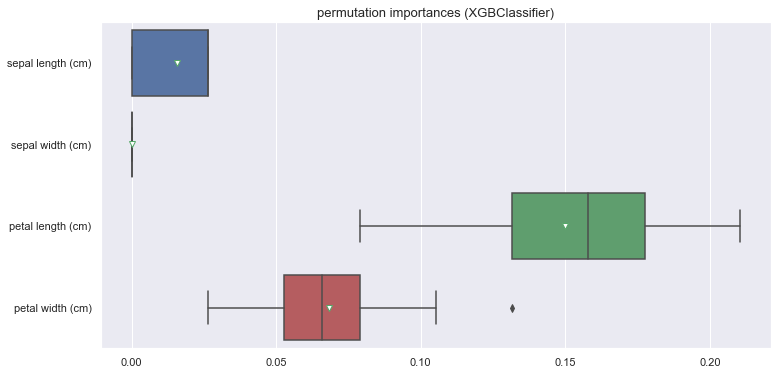

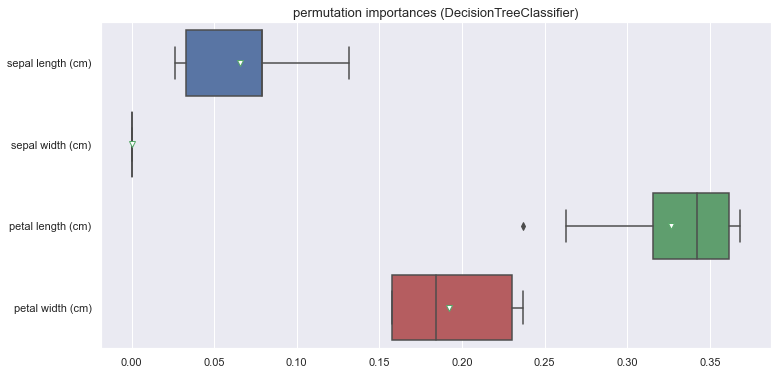

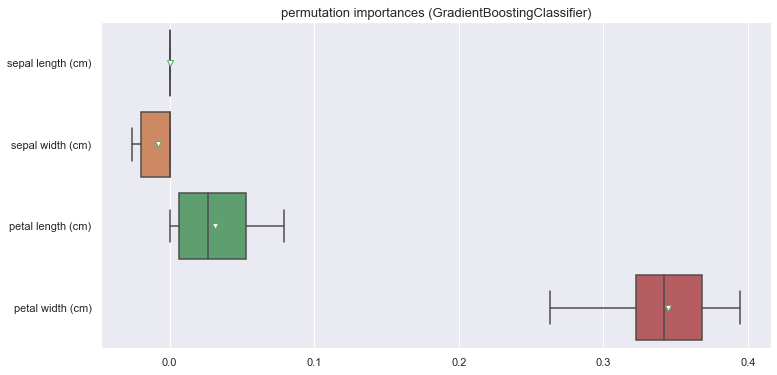

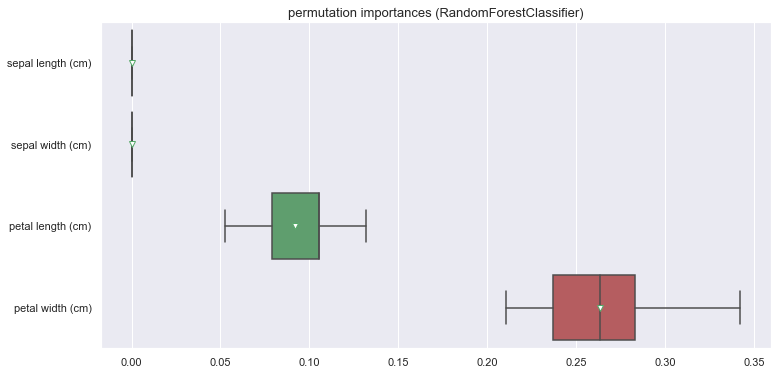

In [155]:
clf.permutation_importances()

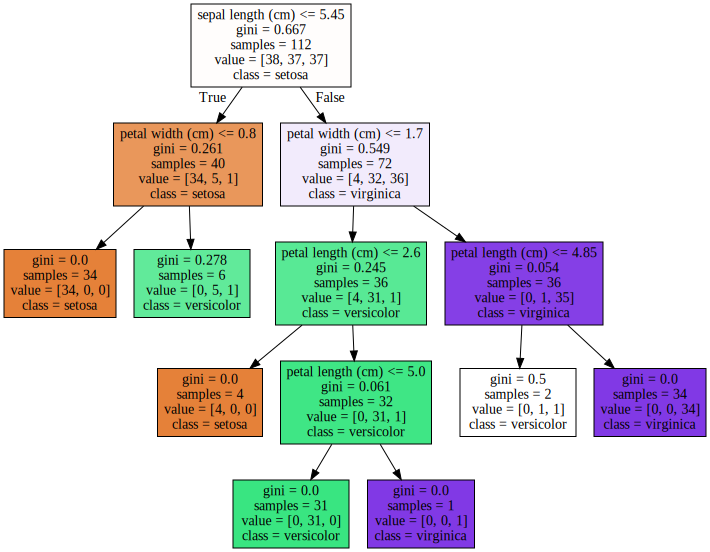

In [156]:
clf._tree_viz(feature_name=df_iris.columns[:-1], class_name=iris.target_names)

# Test

## 체스

In [230]:
games = pd.read_csv('games.csv')
games.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [231]:
col = ['victory_status', 'turns', 'white_rating', 'black_rating', 'opening_ply', 'winner']
dataset = games[col].copy()

In [232]:
dataset.rename(columns={'winner':'labels'}, inplace = True)

In [233]:
dataset = pd.concat(
    [pd.get_dummies(dataset['victory_status'], prefix='victory_status'),
     dataset.drop(columns='victory_status', axis=0)],
    axis=1
)

In [234]:
dataset.labels.value_counts(normalize=True)

white    0.498604
black    0.454033
draw     0.047363
Name: labels, dtype: float64

In [235]:
dataset = dataset[dataset['labels']!='draw'].reset_index(drop=True)

In [236]:
dataset.labels.value_counts(normalize=True)

white    0.523393
black    0.476607
Name: labels, dtype: float64

In [237]:
dataset['labels'] = dataset['labels'].apply(lambda x: 0 if x=='white' else 1)

In [242]:
clf = ClassifierModel(
    data=dataset,
    algo_name=[
        'DecisionTreeClassifier',
        'LogisticRegression',
        'RandomForestClassifier',
        'GradientBoostingClassifier',
        'XGBClassifier',
        'LGBMClassifier'
    ],
    search='random',
    scoring='accuracy',
    n_splits=5,
    n_repeats=5,
    kfold='RepeatedStratifiedKFold',
    feature_scaling='MinMaxScaler',
    random_state=42
)

>>> Check performane with default parameters. (K-Fold: 5, CV iterations: 5)
---------------------------------------------------
LGBMClassifier start
LGBMClassifier end (elapsed_time: 11s)
---------------------------------------------------
XGBClassifier start
XGBClassifier end (elapsed_time: 30s)
---------------------------------------------------
DecisionTreeClassifier start
DecisionTreeClassifier end (elapsed_time: 2s)
---------------------------------------------------
GradientBoostingClassifier start
GradientBoostingClassifier end (elapsed_time: 45s)
---------------------------------------------------
LogisticRegression start
LogisticRegression end (elapsed_time: 2s)
---------------------------------------------------
RandomForestClassifier start
RandomForestClassifier end (elapsed_time: 61s)


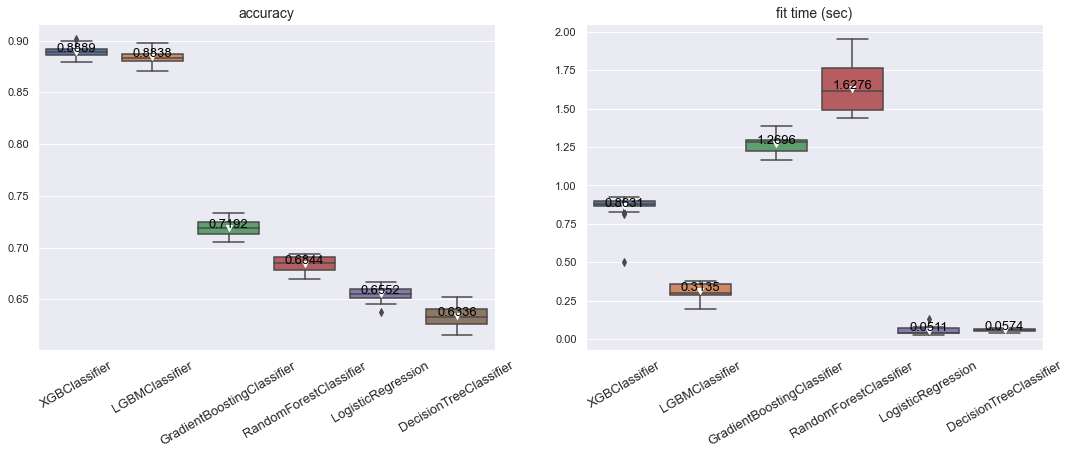

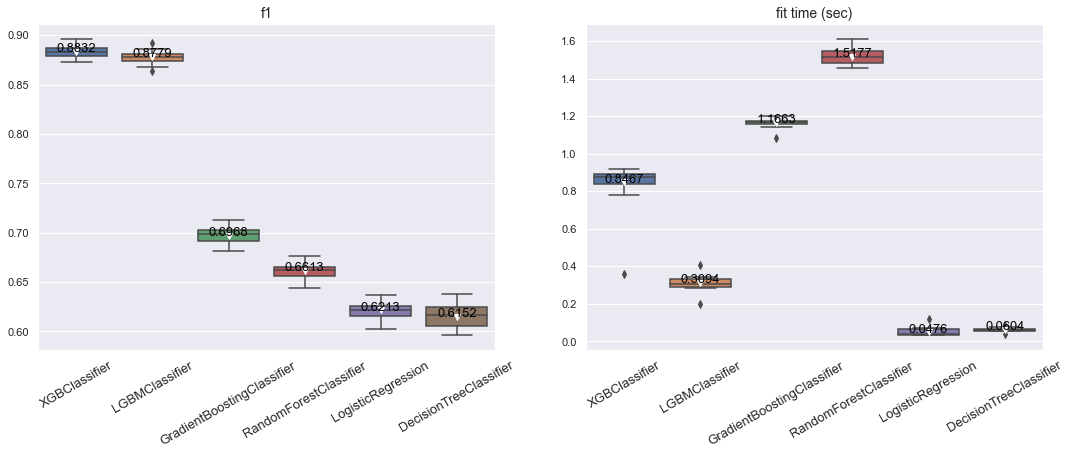

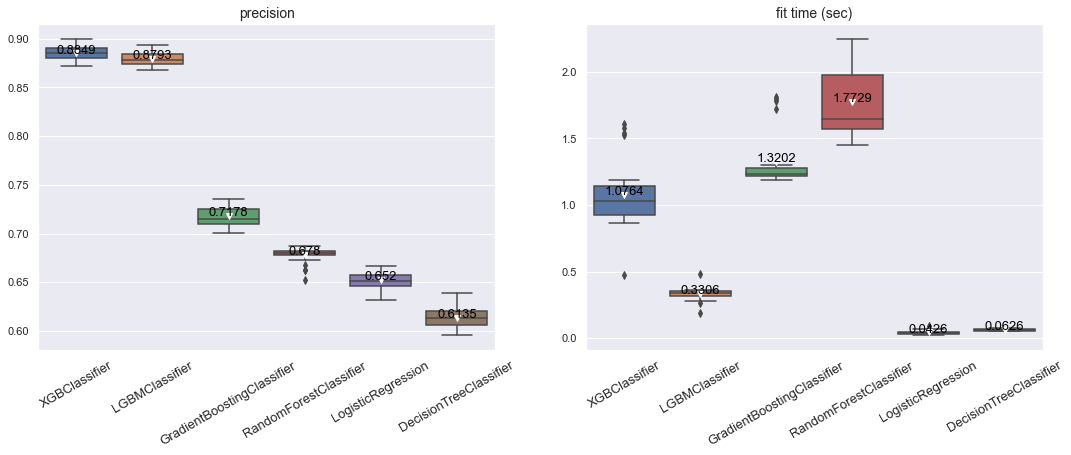

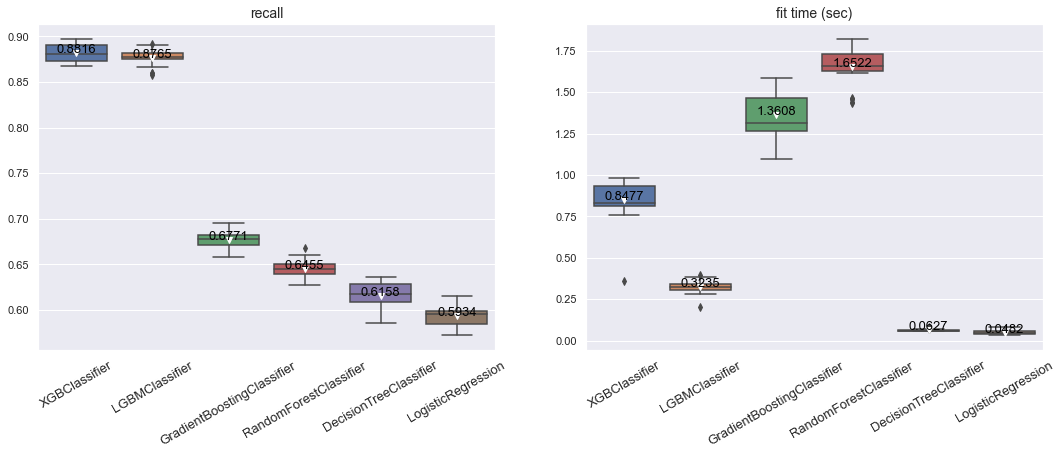

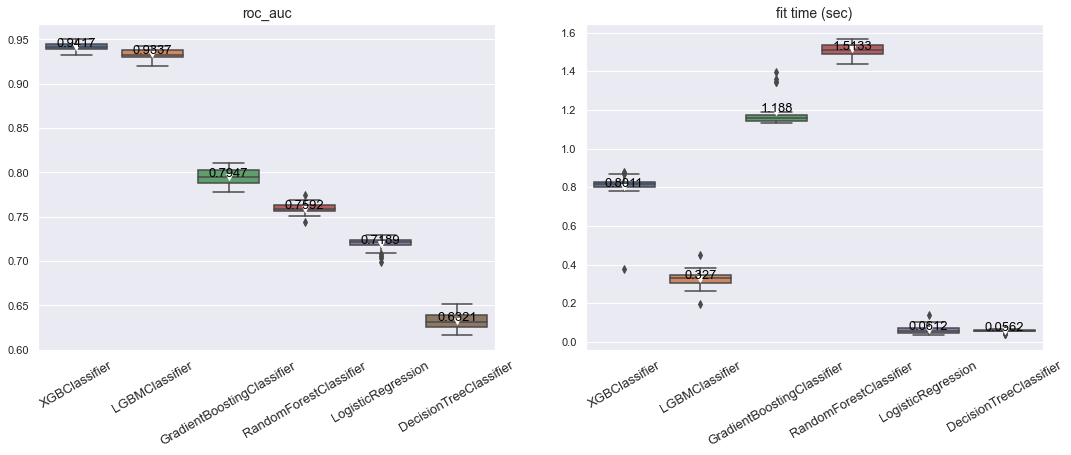

In [239]:
df_scores = clf.cv_with_default_params()

>>> Search best parameters. (K-Fold: 5, CV iterations: 5)
---------------------------------------------------
LGBMClassifier start
[1]	valid_0's binary_logloss: 0.687152
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.675564
[3]	valid_0's binary_logloss: 0.672113
[4]	valid_0's binary_logloss: 0.669658
[5]	valid_0's binary_logloss: 0.66224
[6]	valid_0's binary_logloss: 0.659833
[7]	valid_0's binary_logloss: 0.651637
[8]	valid_0's binary_logloss: 0.646401
[9]	valid_0's binary_logloss: 0.644753
[10]	valid_0's binary_logloss: 0.638547
[11]	valid_0's binary_logloss: 0.636636
[12]	valid_0's binary_logloss: 0.635615
[13]	valid_0's binary_logloss: 0.634606
[14]	valid_0's binary_logloss: 0.629355
[15]	valid_0's binary_logloss: 0.628098
[16]	valid_0's binary_logloss: 0.627291
[17]	valid_0's binary_logloss: 0.622985
[18]	valid_0's binary_logloss: 0.619542
[19]	valid_0's binary_logloss: 0.61641
[20]	valid_0's binary_logloss: 0.613862
[21]	valid_0's bin

[225]	valid_0's binary_logloss: 0.33826
[226]	valid_0's binary_logloss: 0.337689
[227]	valid_0's binary_logloss: 0.336839
[228]	valid_0's binary_logloss: 0.335782
[229]	valid_0's binary_logloss: 0.334921
[230]	valid_0's binary_logloss: 0.334955
[231]	valid_0's binary_logloss: 0.334876
[232]	valid_0's binary_logloss: 0.334816
[233]	valid_0's binary_logloss: 0.333747
[234]	valid_0's binary_logloss: 0.333737
[235]	valid_0's binary_logloss: 0.333709
[236]	valid_0's binary_logloss: 0.333856
[237]	valid_0's binary_logloss: 0.333672
[238]	valid_0's binary_logloss: 0.332877
[239]	valid_0's binary_logloss: 0.331588
[240]	valid_0's binary_logloss: 0.331154
[241]	valid_0's binary_logloss: 0.331155
[242]	valid_0's binary_logloss: 0.33058
[243]	valid_0's binary_logloss: 0.330709
[244]	valid_0's binary_logloss: 0.330676
[245]	valid_0's binary_logloss: 0.329938
[246]	valid_0's binary_logloss: 0.329989
[247]	valid_0's binary_logloss: 0.329997
[248]	valid_0's binary_logloss: 0.330007
[249]	valid_0's bi

[480]	valid_0's binary_logloss: 0.286575
[481]	valid_0's binary_logloss: 0.2866
[482]	valid_0's binary_logloss: 0.286652
[483]	valid_0's binary_logloss: 0.286715
[484]	valid_0's binary_logloss: 0.286767
[485]	valid_0's binary_logloss: 0.286798
[486]	valid_0's binary_logloss: 0.286585
[487]	valid_0's binary_logloss: 0.286492
[488]	valid_0's binary_logloss: 0.286302
[489]	valid_0's binary_logloss: 0.286175
[490]	valid_0's binary_logloss: 0.286231
[491]	valid_0's binary_logloss: 0.286005
[492]	valid_0's binary_logloss: 0.286087
[493]	valid_0's binary_logloss: 0.286054
[494]	valid_0's binary_logloss: 0.2859
[495]	valid_0's binary_logloss: 0.285873
[496]	valid_0's binary_logloss: 0.285877
[497]	valid_0's binary_logloss: 0.285718
[498]	valid_0's binary_logloss: 0.285867
[499]	valid_0's binary_logloss: 0.285962
[500]	valid_0's binary_logloss: 0.286065
[501]	valid_0's binary_logloss: 0.286052
[502]	valid_0's binary_logloss: 0.285943
[503]	valid_0's binary_logloss: 0.285737
[504]	valid_0's bina

[749]	valid_0's binary_logloss: 0.280615
[750]	valid_0's binary_logloss: 0.280724
Did not meet early stopping. Best iteration is:
[739]	valid_0's binary_logloss: 0.280538
LGBMClassifier end (elapsed_time: 212s)
best params: {'colsample_bytree': 0.6814774849944587, 'learning_rate': 0.09099999999999998, 'max_depth': 7, 'n_estimators': 750, 'objective': 'binary'}
---------------------------------------------------
XGBClassifier start
[0]	validation_0-logloss:0.69079
[1]	validation_0-logloss:0.69066
[2]	validation_0-logloss:0.69054
[3]	validation_0-logloss:0.68295
[4]	validation_0-logloss:0.68287
[5]	validation_0-logloss:0.68280
[6]	validation_0-logloss:0.68274
[7]	validation_0-logloss:0.67431
[8]	validation_0-logloss:0.67411
[9]	validation_0-logloss:0.67407
[10]	validation_0-logloss:0.66792
[11]	validation_0-logloss:0.66609
[12]	validation_0-logloss:0.66607
[13]	validation_0-logloss:0.66591
[14]	validation_0-logloss:0.66590
[15]	validation_0-logloss:0.66577
[16]	validation_0-logloss:0.663

[225]	validation_0-logloss:0.54508
[226]	validation_0-logloss:0.54508
[227]	validation_0-logloss:0.54508
[228]	validation_0-logloss:0.54508
[229]	validation_0-logloss:0.54508
[230]	validation_0-logloss:0.54509
[231]	validation_0-logloss:0.54509
[232]	validation_0-logloss:0.54509
[233]	validation_0-logloss:0.54509
[234]	validation_0-logloss:0.54509
[235]	validation_0-logloss:0.54474
[236]	validation_0-logloss:0.54474
[237]	validation_0-logloss:0.54445
[238]	validation_0-logloss:0.54409
[239]	validation_0-logloss:0.54409
[240]	validation_0-logloss:0.54409
[241]	validation_0-logloss:0.54409
[242]	validation_0-logloss:0.54409
[243]	validation_0-logloss:0.54409
[244]	validation_0-logloss:0.54386
[245]	validation_0-logloss:0.54386
[246]	validation_0-logloss:0.54386
[247]	validation_0-logloss:0.54386
[248]	validation_0-logloss:0.54373
[249]	validation_0-logloss:0.54111
[250]	validation_0-logloss:0.54075
[251]	validation_0-logloss:0.54059
[252]	validation_0-logloss:0.54042
[253]	validation_0-l

[460]	validation_0-logloss:0.47845
[461]	validation_0-logloss:0.47845
[462]	validation_0-logloss:0.47736
[463]	validation_0-logloss:0.47731
[464]	validation_0-logloss:0.47680
[465]	validation_0-logloss:0.47516
[466]	validation_0-logloss:0.47516
[467]	validation_0-logloss:0.47516
[468]	validation_0-logloss:0.47512
[469]	validation_0-logloss:0.47357
[470]	validation_0-logloss:0.47357
[471]	validation_0-logloss:0.47358
[472]	validation_0-logloss:0.47358
[473]	validation_0-logloss:0.47358
[474]	validation_0-logloss:0.47358
[475]	validation_0-logloss:0.47358
[476]	validation_0-logloss:0.47358
[477]	validation_0-logloss:0.47358
[478]	validation_0-logloss:0.47358
[479]	validation_0-logloss:0.47352
[480]	validation_0-logloss:0.47352
[481]	validation_0-logloss:0.47350
[482]	validation_0-logloss:0.47350
[483]	validation_0-logloss:0.47344
[484]	validation_0-logloss:0.47344
[485]	validation_0-logloss:0.47344
[486]	validation_0-logloss:0.47351
[487]	validation_0-logloss:0.47351
[488]	validation_0-l

[695]	validation_0-logloss:0.42098
[696]	validation_0-logloss:0.42098
[697]	validation_0-logloss:0.42105
[698]	validation_0-logloss:0.42110
[699]	validation_0-logloss:0.42117
[700]	validation_0-logloss:0.41940
[701]	validation_0-logloss:0.41947
[702]	validation_0-logloss:0.41948
[703]	validation_0-logloss:0.41949
[704]	validation_0-logloss:0.41949
[705]	validation_0-logloss:0.41949
[706]	validation_0-logloss:0.41958
[707]	validation_0-logloss:0.41958
[708]	validation_0-logloss:0.41958
[709]	validation_0-logloss:0.41958
[710]	validation_0-logloss:0.41958
[711]	validation_0-logloss:0.41958
[712]	validation_0-logloss:0.41958
[713]	validation_0-logloss:0.41958
[714]	validation_0-logloss:0.41958
[715]	validation_0-logloss:0.41958
[716]	validation_0-logloss:0.41958
[717]	validation_0-logloss:0.41764
[718]	validation_0-logloss:0.41766
[719]	validation_0-logloss:0.41766
[720]	validation_0-logloss:0.41766
[721]	validation_0-logloss:0.41766
[722]	validation_0-logloss:0.41767
[723]	validation_0-l

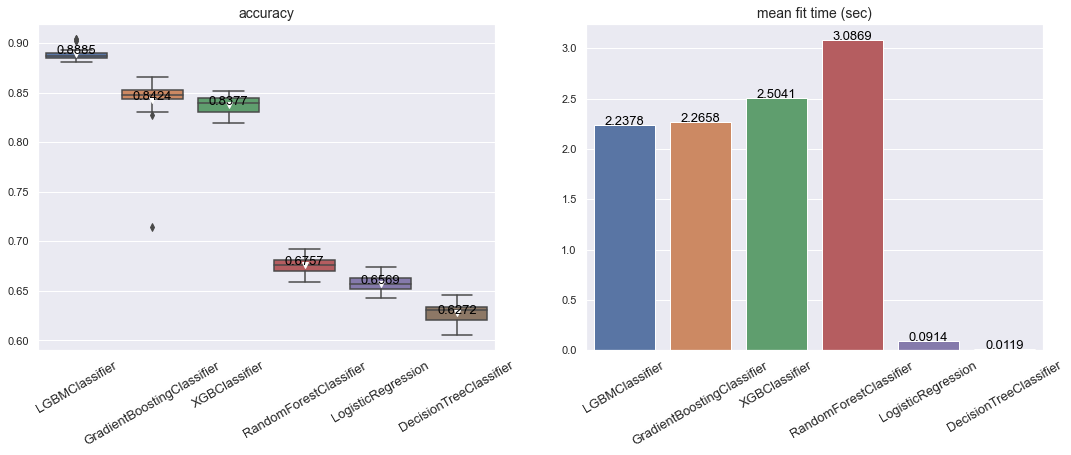

In [243]:
clf.search_params()

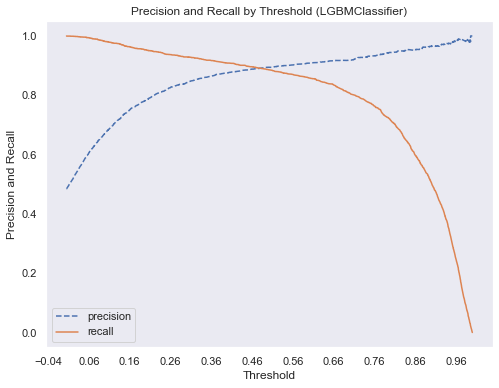

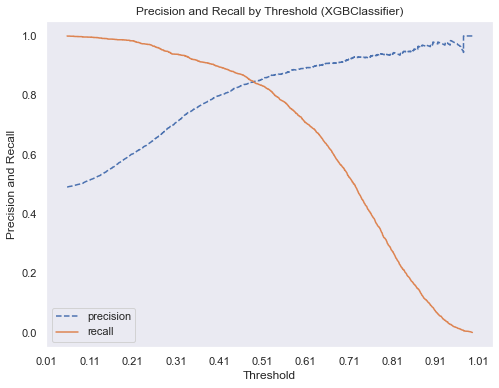

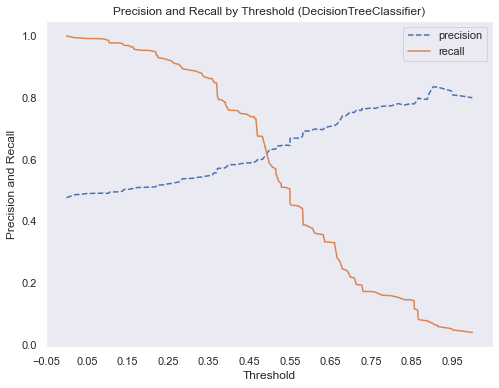

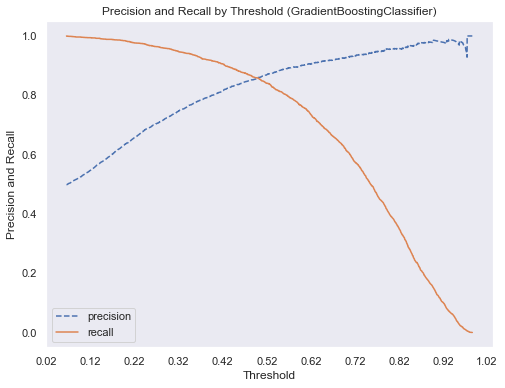

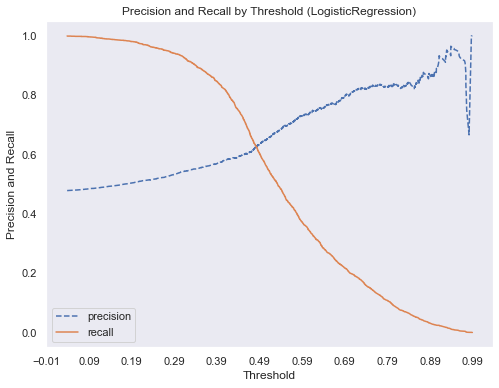

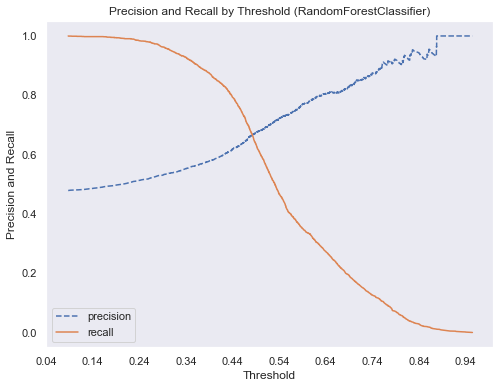

In [244]:
clf.precision_recall_by_thresholds()

LGBMClassifier
XGBClassifier
DecisionTreeClassifier
GradientBoostingClassifier
LogisticRegression
RandomForestClassifier


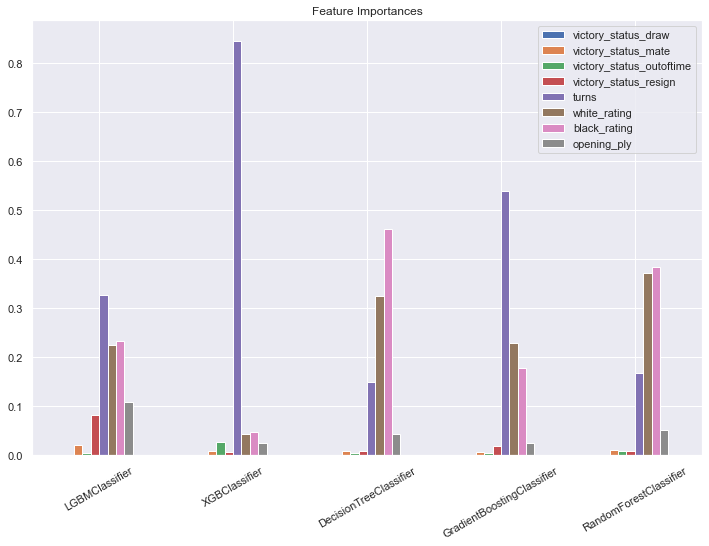

In [245]:
clf.feature_importances()

In [246]:
clf._best_model()

{'mean_test_score': 0.8875026427492284,
 'std_test_score': 0.00559604428743544,
 'mean_fit_time': 1.671393690109253,
 'algo_name': 'LGBMClassifier',
 'params': {'colsample_bytree': 0.7675282017063904,
  'learning_rate': 0.09099999999999998,
  'max_depth': 6,
  'n_estimators': 600,
  'objective': 'binary'}}

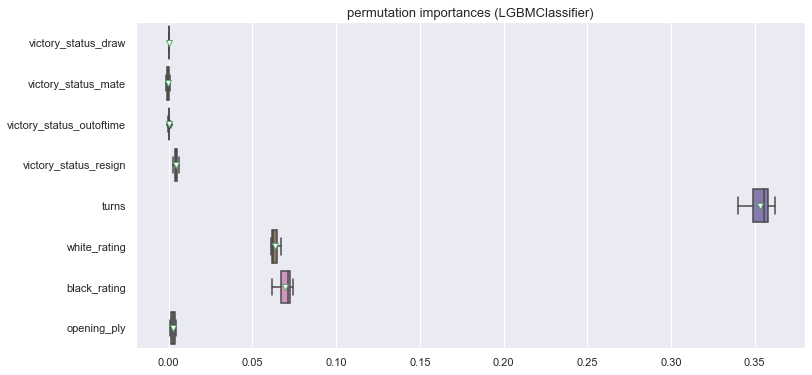

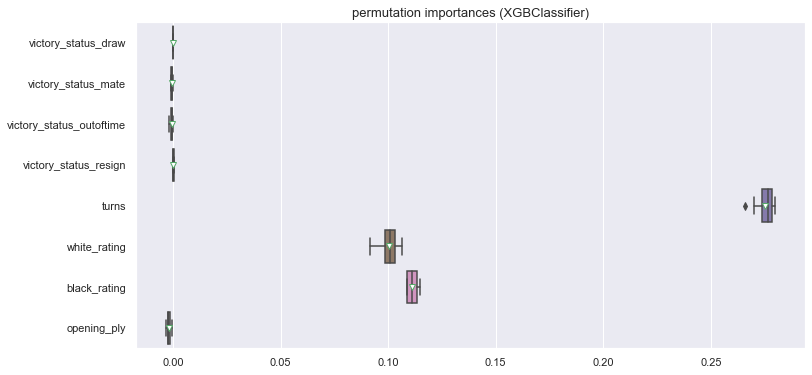

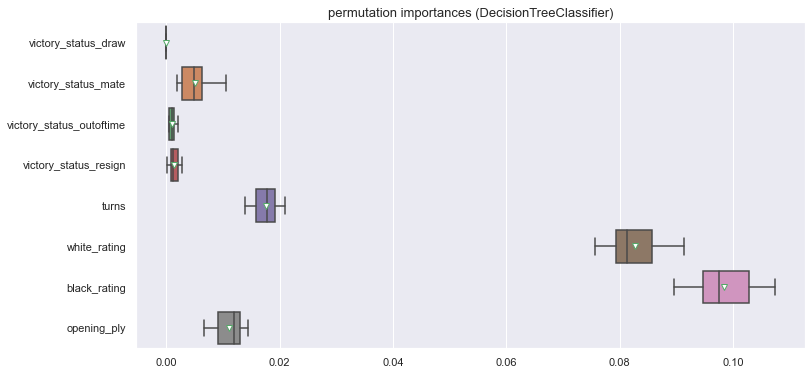

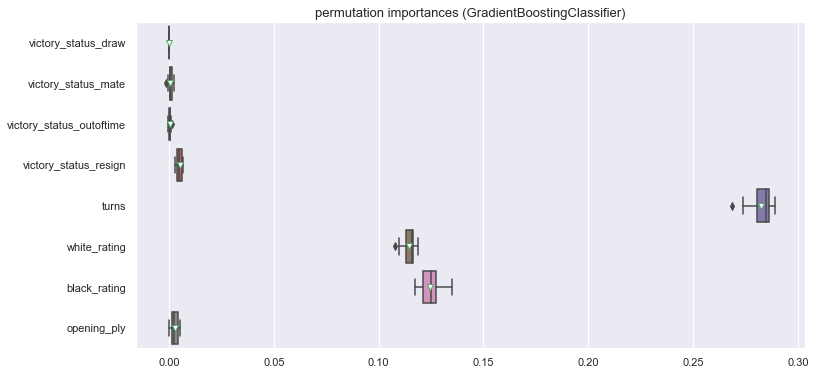

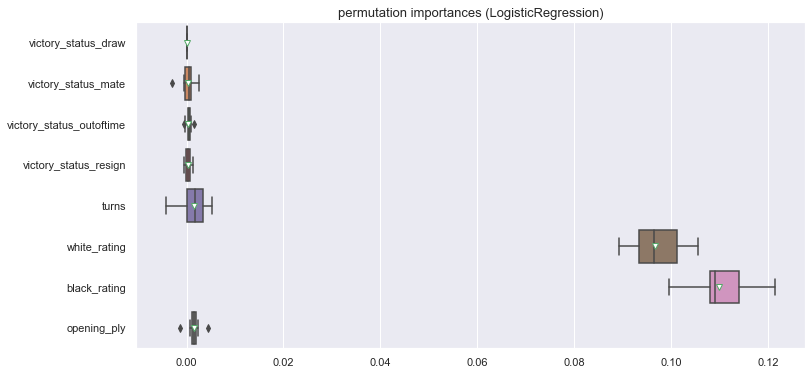

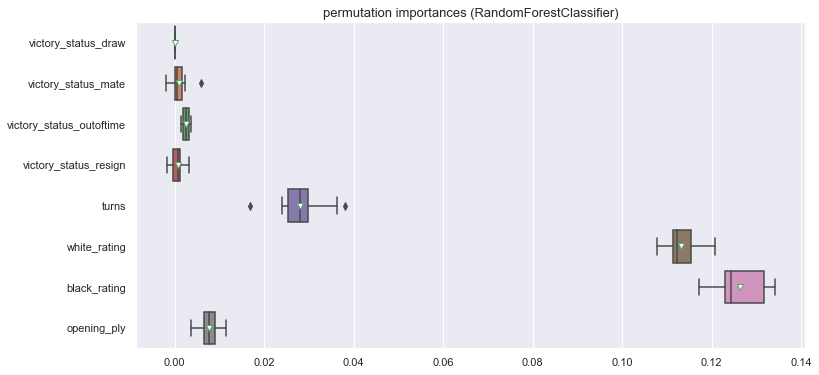

In [247]:
clf.permutation_importances()

In [248]:
model = clf.final_classifer()
pred = model.predict(dataset.iloc[:, :-1].values)
print(accuracy_score(dataset['labels'], pred))

>>> Predict from new data.
0.9294012978857024


In [249]:
dataset.iloc[:2,:]

,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,turns,white_rating,black_rating,opening_ply,labels
0,0,0,1,0,13,1500,1191,5,0
1,0,0,0,1,16,1322,1261,4,1


In [250]:
model = load('GradientBoostingClassifier.joblib')
model.predict(dataset.iloc[:2,:-1].to_numpy())

array([0, 1], dtype=int64)

## 산탄데르